In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
os.chdir("../..")


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json
import time

from tqdm import tqdm


In [4]:
from qml.tools.random import XRandomGenerator


In [5]:
from qml.db import target as xtarget
from qml.db.ml import MLDatasetGenerator

# step 0
from qml.db.ml import MLDatasetGenerator

# step 1
from qml.model.encoding import EncodingUnitManager
from qml.model.model import Model

# step 2
from qml.optimizer import evaluator as xeval

# step 3
from qml.model.unit import UnitManager

# step 4: train candidates
from qml import optimizer as xoptim


In [6]:
class DPODatasetGenerator:

    def __init__(
            self,
            target_function_generator: xtarget.TargetFunctionGenerator,
    ):
        pass


### Procedure de faire la dataset pour OCGTraining

#### parameters
Nc: Number of candidates in single dataset

#### avec Random Units
0. Generate random taget dataset
1. Prepare MQC avec Encoding
2. Calculate Wavelet seriese and loss -> wseries, loss_avons
3. Append candidate units x Nc --> units: json
4. Training candidates
5. Calculate loss --> loss_apres
6. Store into db --> db = db & {wseries, units, loss_apres}

7. repeat step 2 - 5 until loss threashold {threashold_loss} ou max number for repeats {num_iter_elever}

## Parameters

In [7]:
# qmc
num_qubits = 2

# target dataset
db_size = 10
dim_order = 4

# wavelet
wavelet_dim = 4

# candidates
num_gates = 3
num_candidates = 5

# candidate training
max_iter = 20


In [16]:
# db
db_file_name = "dpo_dataset_0.txt"
num_data = 0


### 0. Generate random target dataset

In [17]:
tfun = xtarget.PolynominalTargetFunctionGenerator(dim_order)
tgen = MLDatasetGenerator(tfun)
tdataset = tgen.generate(db_size)


### 1. Prepare MQC

In [18]:
eunit = EncodingUnitManager.AngleEncoding(1, num_qubits, repeat=True)
model = Model(num_qubits, 1, eunit, [], [])


### 2. Calc wavelet seriese and loss

In [32]:
wevaluator = xeval.WaveletEvaluator(xeval.Haar(), tdataset, model, wavelet_dim=wavelet_dim)
wresult = wevaluator()
wresult.powers


array([-0.61655818, -0.71719184,  0.56243874, -0.36459933, -0.28506377,
        0.51359565,  0.05328097, -0.29725074,  0.07888017, -0.22156591,
       -0.03888941,  0.47882589, -0.19242844,  0.06722817,  0.13332276])

### 3. Append candidate units

In [20]:
# generate and append candidate units
uman = UnitManager(num_qubits, num_gates)


In [33]:
# fix previous round trainable unit
model.fix_trainable_units()

def generate_candidate():
    candidate_unit = uman.generate_random_unit(name=f"unit_{uman.num_generated:04}")
    return candidate_unit

candidate_units = [generate_candidate() for _ in range(num_candidates)]
candidate_models = [
    Model(model.nq, 1, model.input_units, model.fixed_units, candidate_unit)
    for candidate_unit in candidate_units
]


### 4. Train candidates

In [34]:
def train_candidate(candidate_model, tdataset):
    train_optimizer = xoptim.LocalSearchOptimizer(tdataset)
    train_result = train_optimizer.optimize(candidate_model, max_iter, verbose=False)
    return train_result

train_results = [
    train_candidate(candidate_model, tdataset)
    for candidate_model in candidate_models
]


### 5. Calc loss apres training

In [35]:
loss_evaluator = xeval.MSEEvaluator(tdataset, model)
lresults = [loss_evaluator(train_result.first.x, candidate_model) for train_result, candidate_model in zip(train_results, candidate_models)]


### 6. Store as db data

In [36]:
data = dict(
    wseries=wresult.powers.tolist(),
    units=[candidate_unit.to_dict() for candidate_unit in candidate_units],
    losses=[float(lresult.loss) for lresult in lresults],
)
with open(db_file_name, mode="a") as f:
    print(json.dumps(data), file=f)


### 7. Update

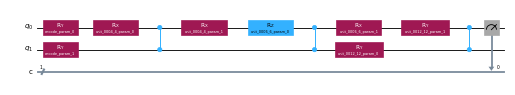

In [37]:
best_model_id = np.argmin(data["losses"])
best_model = candidate_models[best_model_id]
model = best_model

fig, ax = plt.subplots()
model.draw(ax)


In [8]:
class DPODatasetGenerator:

    WAVELET_CLASS = xeval.Haar

    def __init__(
            self,
            num_qubits: int,
            num_gates: int,
            max_order: int,
            max_repeat_for_target: int = 3,
            # step 0
            qml_db_size: int = 50,
            db_filename = "dpo_databsae.txt",
            # step 1
            # step 2
            wavelet_class: xeval.Wavelet = None,
            wavelet_dim: int = 4,
            # step 3
            num_candidates: int = 5,
            # step 4
            qml_max_iter: int = 50,
            qml_batch_size: int = None,
            seed: int = None,
    ) -> None:
        self.rng = rng = XRandomGenerator(seed)
        self.num_qubits = nq = num_qubits
        self.num_gates = ng = num_gates
        self.max_repeat_for_target = max_repeat_for_target

        # step 0 target function
        self.max_order = d = max_order
        self.tfun = xtarget.PolynominalTargetFunctionGenerator(d, rng.new_seed())
        self.tgen = MLDatasetGenerator(self.tfun, rng.new_seed())
        self.qml_db_size = qml_db_size
        self.db_filename = db_filename

        # step 1 prepare mqc

        # step 2 calc wavelet series
        if wavelet_class is None:
            wavelet_class = self.WAVELET_CLASS
        self.wavelet_class = wavelet_class
        self.wavelet_dim = wavelet_dim
        
        # step 3
        self.uman = UnitManager(nq, ng, rng.new_seed())
        self.num_candidates = num_candidates

        # step 4 tain candidate
        self.qml_max_iter = qml_max_iter
        self.qml_batch_size = qml_batch_size
    
    def initialize_qml_and_model(self):
        # step 0 generate qml database
        qml_dataset = self.tgen.generate(self.qml_db_size)

        # step 1 prepare mqc
        eunit = EncodingUnitManager.AngleEncoding(1, self.num_qubits, repeat=True)
        model = Model(self.num_qubits, 1, eunit, [], [])
        
        return qml_dataset, model
    
    def generate(
            self,
            size: int,
            db_filename: str = None,
            batch_size: int = None,
    ):
        if db_filename is None:
            db_filename = self.db_filename
        batch_size = self.qml_batch_size if batch_size is None else batch_size

        num_data = 0
        
        while True:
            print("num_data:", num_data)

            # step 0. generate qml database with target func
            # step 1. prepare mqc
            qml_dataset, model = self.initialize_qml_and_model()

            for _ in range(self.max_repeat_for_target):
                print(f"round:{num_data:>4d}", end="\t")
                # step 2. calc wavelet seriese
                wave_evaluator = xeval.WaveletEvaluator(self.wavelet_class(), qml_dataset, model, wavelet_dim=self.wavelet_dim)
                wave_result = wave_evaluator()

                model.fix_trainable_units()

                loss_results = []
                candidate_units = []
                candidate_models = []
                for _ in tqdm(range(self.num_candidates)):
                    # step 3. append candidate units
                    candidate_unit = self.uman.generate_random_unit()
                    candidate_units.append(candidate_unit)
                    candidate_model = Model(model.nq, 1, model.input_units, model.fixed_units, candidate_unit)
                    candidate_models.append(candidate_model)

                    # step 4. train candidates
                    train_optimizer = xoptim.LocalSearchOptimizer(qml_dataset)
                    train_result = train_optimizer.optimize(
                        candidate_model,
                        self.qml_max_iter,
                        batch_size=batch_size,
                        verbose=False
                    )

                    # step 5. calc loss after training
                    loss_evaluator = xeval.MSEEvaluator(qml_dataset, candidate_model)
                    loss_result = loss_evaluator(train_result.first.x, candidate_model)
                    loss_results.append(loss_result)

                # step 6. store as db
                data = dict(
                    wseries=wave_result.powers.tolist(),
                    units=[candidate_unit.to_dict() for candidate_unit  in candidate_units],
                    losses=[float(loss_result.loss) for loss_result in loss_results],
                )
                print("[info] saving data into:", db_filename)
                with open(db_filename, mode="a") as f:
                    print(json.dumps(data), file=f)
                num_data += 1

                # check generated data size
                if num_data >= size:
                    return db_filename

                # if trained model reaches near-optimal --> create new problem set
                if np.min(data["losses"]) <= 1e-3:
                    break
                
                # update current model
                best_candidate_no = np.argmin(data["losses"])
                model = candidate_models[best_candidate_no]

            

ddgen = DPODatasetGenerator(
    num_qubits, num_gates, dim_order,
    max_repeat_for_target = 3,
    # step 0
    qml_db_size = 50,
    db_filename = "dpo_databsae.txt",
    # step 1
    # step 2
    wavelet_class = None,
    wavelet_dim = 8,
    # step 3
    num_candidates = 5,
    # step 4
    qml_max_iter = 50,
    qml_batch_size=20
)
# ddgen = DPODatasetGenerator(num_qubits, num_gates, dim_order, qml_batch_size=10, qml_max_iter=50)
ddgen.generate(500)


num_data: 0
round:   0	

100%|██████████| 5/5 [02:24<00:00, 28.98s/it]


[info] saving data into: dpo_databsae.txt
round:   1	

100%|██████████| 5/5 [02:25<00:00, 29.08s/it]


[info] saving data into: dpo_databsae.txt
round:   2	

100%|██████████| 5/5 [02:25<00:00, 29.02s/it]


[info] saving data into: dpo_databsae.txt
num_data: 3
round:   3	

100%|██████████| 5/5 [02:24<00:00, 28.96s/it]


[info] saving data into: dpo_databsae.txt
round:   4	

100%|██████████| 5/5 [02:24<00:00, 28.99s/it]


[info] saving data into: dpo_databsae.txt
round:   5	

100%|██████████| 5/5 [02:24<00:00, 29.00s/it]


[info] saving data into: dpo_databsae.txt
num_data: 6
round:   6	

100%|██████████| 5/5 [32:12<00:00, 386.48s/it]


[info] saving data into: dpo_databsae.txt
round:   7	

100%|██████████| 5/5 [49:57<00:00, 599.41s/it]


[info] saving data into: dpo_databsae.txt
round:   8	

100%|██████████| 5/5 [36:34<00:00, 438.82s/it]  


[info] saving data into: dpo_databsae.txt
num_data: 9
round:   9	

100%|██████████| 5/5 [14:05<00:00, 169.11s/it]


[info] saving data into: dpo_databsae.txt
round:  10	

100%|██████████| 5/5 [02:24<00:00, 28.93s/it]


[info] saving data into: dpo_databsae.txt
round:  11	

100%|██████████| 5/5 [02:25<00:00, 29.03s/it]


[info] saving data into: dpo_databsae.txt
num_data: 12
round:  12	

100%|██████████| 5/5 [02:24<00:00, 28.95s/it]


[info] saving data into: dpo_databsae.txt
round:  13	

100%|██████████| 5/5 [06:48<00:00, 81.71s/it] 


[info] saving data into: dpo_databsae.txt
round:  14	

100%|██████████| 5/5 [08:28<00:00, 101.73s/it]


[info] saving data into: dpo_databsae.txt
num_data: 15
round:  15	

100%|██████████| 5/5 [02:26<00:00, 29.25s/it]


[info] saving data into: dpo_databsae.txt
round:  16	

100%|██████████| 5/5 [02:22<00:00, 28.47s/it]


[info] saving data into: dpo_databsae.txt
round:  17	

100%|██████████| 5/5 [02:22<00:00, 28.55s/it]


[info] saving data into: dpo_databsae.txt
num_data: 18
round:  18	

100%|██████████| 5/5 [02:22<00:00, 28.49s/it]


[info] saving data into: dpo_databsae.txt
round:  19	

100%|██████████| 5/5 [02:22<00:00, 28.49s/it]


[info] saving data into: dpo_databsae.txt
round:  20	

100%|██████████| 5/5 [02:22<00:00, 28.56s/it]


[info] saving data into: dpo_databsae.txt
num_data: 21
round:  21	

100%|██████████| 5/5 [02:22<00:00, 28.44s/it]


[info] saving data into: dpo_databsae.txt
round:  22	

100%|██████████| 5/5 [02:22<00:00, 28.48s/it]


[info] saving data into: dpo_databsae.txt
round:  23	

100%|██████████| 5/5 [02:22<00:00, 28.54s/it]


[info] saving data into: dpo_databsae.txt
num_data: 24
round:  24	

100%|██████████| 5/5 [02:22<00:00, 28.47s/it]


[info] saving data into: dpo_databsae.txt
round:  25	

100%|██████████| 5/5 [02:22<00:00, 28.45s/it]


[info] saving data into: dpo_databsae.txt
round:  26	

100%|██████████| 5/5 [02:22<00:00, 28.50s/it]


[info] saving data into: dpo_databsae.txt
num_data: 27
round:  27	

100%|██████████| 5/5 [02:17<00:00, 27.59s/it]


[info] saving data into: dpo_databsae.txt
round:  28	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
round:  29	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
num_data: 30
round:  30	

100%|██████████| 5/5 [02:22<00:00, 28.49s/it]


[info] saving data into: dpo_databsae.txt
round:  31	

100%|██████████| 5/5 [02:22<00:00, 28.48s/it]


[info] saving data into: dpo_databsae.txt
round:  32	

100%|██████████| 5/5 [02:22<00:00, 28.57s/it]


[info] saving data into: dpo_databsae.txt
num_data: 33
round:  33	

100%|██████████| 5/5 [02:22<00:00, 28.48s/it]


[info] saving data into: dpo_databsae.txt
round:  34	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
round:  35	

100%|██████████| 5/5 [02:23<00:00, 28.60s/it]


[info] saving data into: dpo_databsae.txt
num_data: 36
round:  36	

100%|██████████| 5/5 [02:22<00:00, 28.42s/it]


[info] saving data into: dpo_databsae.txt
round:  37	

100%|██████████| 5/5 [02:22<00:00, 28.55s/it]


[info] saving data into: dpo_databsae.txt
round:  38	

100%|██████████| 5/5 [02:27<00:00, 29.42s/it]


[info] saving data into: dpo_databsae.txt
num_data: 39
round:  39	

100%|██████████| 5/5 [02:25<00:00, 29.02s/it]


[info] saving data into: dpo_databsae.txt
round:  40	

100%|██████████| 5/5 [02:24<00:00, 28.91s/it]


[info] saving data into: dpo_databsae.txt
round:  41	

100%|██████████| 5/5 [02:24<00:00, 28.94s/it]


[info] saving data into: dpo_databsae.txt
num_data: 42
round:  42	

100%|██████████| 5/5 [02:24<00:00, 28.89s/it]


[info] saving data into: dpo_databsae.txt
round:  43	

100%|██████████| 5/5 [02:24<00:00, 28.80s/it]


[info] saving data into: dpo_databsae.txt
round:  44	

100%|██████████| 5/5 [02:22<00:00, 28.46s/it]


[info] saving data into: dpo_databsae.txt
num_data: 45
round:  45	

100%|██████████| 5/5 [02:22<00:00, 28.51s/it]


[info] saving data into: dpo_databsae.txt
round:  46	

100%|██████████| 5/5 [02:22<00:00, 28.48s/it]


[info] saving data into: dpo_databsae.txt
round:  47	

100%|██████████| 5/5 [02:22<00:00, 28.53s/it]


[info] saving data into: dpo_databsae.txt
num_data: 48
round:  48	

100%|██████████| 5/5 [02:22<00:00, 28.46s/it]


[info] saving data into: dpo_databsae.txt
round:  49	

100%|██████████| 5/5 [02:22<00:00, 28.50s/it]


[info] saving data into: dpo_databsae.txt
round:  50	

100%|██████████| 5/5 [02:22<00:00, 28.48s/it]


[info] saving data into: dpo_databsae.txt
num_data: 51
round:  51	

100%|██████████| 5/5 [02:22<00:00, 28.43s/it]


[info] saving data into: dpo_databsae.txt
round:  52	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
round:  53	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
num_data: 54
round:  54	

100%|██████████| 5/5 [02:22<00:00, 28.43s/it]


[info] saving data into: dpo_databsae.txt
round:  55	

100%|██████████| 5/5 [02:22<00:00, 28.54s/it]


[info] saving data into: dpo_databsae.txt
round:  56	

100%|██████████| 5/5 [02:25<00:00, 29.07s/it]


[info] saving data into: dpo_databsae.txt
num_data: 57
round:  57	

100%|██████████| 5/5 [02:24<00:00, 28.94s/it]


[info] saving data into: dpo_databsae.txt
round:  58	

100%|██████████| 5/5 [02:25<00:00, 29.03s/it]


[info] saving data into: dpo_databsae.txt
round:  59	

100%|██████████| 5/5 [02:24<00:00, 28.98s/it]


[info] saving data into: dpo_databsae.txt
num_data: 60
round:  60	

100%|██████████| 5/5 [02:23<00:00, 28.65s/it]


[info] saving data into: dpo_databsae.txt
round:  61	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
round:  62	

100%|██████████| 5/5 [02:22<00:00, 28.56s/it]


[info] saving data into: dpo_databsae.txt
num_data: 63
round:  63	

100%|██████████| 5/5 [02:22<00:00, 28.42s/it]


[info] saving data into: dpo_databsae.txt
round:  64	

100%|██████████| 5/5 [02:22<00:00, 28.51s/it]


[info] saving data into: dpo_databsae.txt
round:  65	

100%|██████████| 5/5 [02:22<00:00, 28.59s/it]


[info] saving data into: dpo_databsae.txt
num_data: 66
round:  66	

100%|██████████| 5/5 [02:22<00:00, 28.49s/it]


[info] saving data into: dpo_databsae.txt
round:  67	

100%|██████████| 5/5 [02:22<00:00, 28.48s/it]


[info] saving data into: dpo_databsae.txt
round:  68	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
num_data: 69
round:  69	

100%|██████████| 5/5 [02:22<00:00, 28.45s/it]


[info] saving data into: dpo_databsae.txt
round:  70	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
round:  71	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
num_data: 72
round:  72	

100%|██████████| 5/5 [02:22<00:00, 28.47s/it]


[info] saving data into: dpo_databsae.txt
round:  73	

100%|██████████| 5/5 [02:22<00:00, 28.51s/it]


[info] saving data into: dpo_databsae.txt
round:  74	

100%|██████████| 5/5 [02:22<00:00, 28.51s/it]


[info] saving data into: dpo_databsae.txt
num_data: 75
round:  75	

100%|██████████| 5/5 [02:22<00:00, 28.44s/it]


[info] saving data into: dpo_databsae.txt
round:  76	

100%|██████████| 5/5 [02:22<00:00, 28.50s/it]


[info] saving data into: dpo_databsae.txt
round:  77	

100%|██████████| 5/5 [02:22<00:00, 28.53s/it]


[info] saving data into: dpo_databsae.txt
num_data: 78
round:  78	

100%|██████████| 5/5 [02:22<00:00, 28.50s/it]


[info] saving data into: dpo_databsae.txt
round:  79	

100%|██████████| 5/5 [02:22<00:00, 28.51s/it]


[info] saving data into: dpo_databsae.txt
round:  80	

100%|██████████| 5/5 [02:23<00:00, 28.60s/it]


[info] saving data into: dpo_databsae.txt
num_data: 81
round:  81	

100%|██████████| 5/5 [02:22<00:00, 28.48s/it]


[info] saving data into: dpo_databsae.txt
round:  82	

100%|██████████| 5/5 [02:22<00:00, 28.48s/it]


[info] saving data into: dpo_databsae.txt
round:  83	

100%|██████████| 5/5 [02:22<00:00, 28.58s/it]


[info] saving data into: dpo_databsae.txt
num_data: 84
round:  84	

100%|██████████| 5/5 [02:22<00:00, 28.49s/it]


[info] saving data into: dpo_databsae.txt
round:  85	

100%|██████████| 5/5 [02:22<00:00, 28.51s/it]


[info] saving data into: dpo_databsae.txt
round:  86	

100%|██████████| 5/5 [02:22<00:00, 28.47s/it]


[info] saving data into: dpo_databsae.txt
num_data: 87
round:  87	

100%|██████████| 5/5 [02:22<00:00, 28.44s/it]


[info] saving data into: dpo_databsae.txt
round:  88	

100%|██████████| 5/5 [02:22<00:00, 28.50s/it]


[info] saving data into: dpo_databsae.txt
round:  89	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
num_data: 90
round:  90	

100%|██████████| 5/5 [02:22<00:00, 28.47s/it]


[info] saving data into: dpo_databsae.txt
round:  91	

100%|██████████| 5/5 [02:22<00:00, 28.51s/it]


[info] saving data into: dpo_databsae.txt
round:  92	

100%|██████████| 5/5 [02:22<00:00, 28.53s/it]


[info] saving data into: dpo_databsae.txt
num_data: 93
round:  93	

100%|██████████| 5/5 [02:22<00:00, 28.48s/it]


[info] saving data into: dpo_databsae.txt
round:  94	

100%|██████████| 5/5 [02:22<00:00, 28.47s/it]


[info] saving data into: dpo_databsae.txt
round:  95	

100%|██████████| 5/5 [02:22<00:00, 28.53s/it]


[info] saving data into: dpo_databsae.txt
num_data: 96
round:  96	

100%|██████████| 5/5 [02:22<00:00, 28.45s/it]


[info] saving data into: dpo_databsae.txt
round:  97	

100%|██████████| 5/5 [02:22<00:00, 28.53s/it]


[info] saving data into: dpo_databsae.txt
round:  98	

100%|██████████| 5/5 [02:22<00:00, 28.59s/it]


[info] saving data into: dpo_databsae.txt
num_data: 99
round:  99	

100%|██████████| 5/5 [02:22<00:00, 28.50s/it]


[info] saving data into: dpo_databsae.txt
round: 100	

100%|██████████| 5/5 [02:22<00:00, 28.50s/it]


[info] saving data into: dpo_databsae.txt
round: 101	

100%|██████████| 5/5 [02:22<00:00, 28.56s/it]


[info] saving data into: dpo_databsae.txt
num_data: 102
round: 102	

100%|██████████| 5/5 [02:22<00:00, 28.47s/it]


[info] saving data into: dpo_databsae.txt
round: 103	

100%|██████████| 5/5 [02:22<00:00, 28.50s/it]


[info] saving data into: dpo_databsae.txt
round: 104	

100%|██████████| 5/5 [02:22<00:00, 28.51s/it]


[info] saving data into: dpo_databsae.txt
num_data: 105
round: 105	

100%|██████████| 5/5 [02:22<00:00, 28.50s/it]


[info] saving data into: dpo_databsae.txt
round: 106	

100%|██████████| 5/5 [02:22<00:00, 28.53s/it]


[info] saving data into: dpo_databsae.txt
round: 107	

100%|██████████| 5/5 [02:22<00:00, 28.56s/it]


[info] saving data into: dpo_databsae.txt
num_data: 108
round: 108	

100%|██████████| 5/5 [02:22<00:00, 28.47s/it]


[info] saving data into: dpo_databsae.txt
round: 109	

100%|██████████| 5/5 [02:22<00:00, 28.44s/it]


[info] saving data into: dpo_databsae.txt
round: 110	

100%|██████████| 5/5 [02:22<00:00, 28.50s/it]


[info] saving data into: dpo_databsae.txt
num_data: 111
round: 111	

100%|██████████| 5/5 [02:22<00:00, 28.44s/it]


[info] saving data into: dpo_databsae.txt
round: 112	

100%|██████████| 5/5 [02:22<00:00, 28.48s/it]


[info] saving data into: dpo_databsae.txt
round: 113	

100%|██████████| 5/5 [02:22<00:00, 28.56s/it]


[info] saving data into: dpo_databsae.txt
num_data: 114
round: 114	

100%|██████████| 5/5 [02:22<00:00, 28.49s/it]


[info] saving data into: dpo_databsae.txt
round: 115	

100%|██████████| 5/5 [02:22<00:00, 28.53s/it]


[info] saving data into: dpo_databsae.txt
round: 116	

100%|██████████| 5/5 [02:22<00:00, 28.49s/it]


[info] saving data into: dpo_databsae.txt
num_data: 117
round: 117	

100%|██████████| 5/5 [02:22<00:00, 28.46s/it]


[info] saving data into: dpo_databsae.txt
round: 118	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
round: 119	

100%|██████████| 5/5 [02:22<00:00, 28.57s/it]


[info] saving data into: dpo_databsae.txt
num_data: 120
round: 120	

100%|██████████| 5/5 [02:22<00:00, 28.47s/it]


[info] saving data into: dpo_databsae.txt
round: 121	

100%|██████████| 5/5 [02:22<00:00, 28.51s/it]


[info] saving data into: dpo_databsae.txt
round: 122	

100%|██████████| 5/5 [02:22<00:00, 28.55s/it]


[info] saving data into: dpo_databsae.txt
num_data: 123
round: 123	

100%|██████████| 5/5 [02:22<00:00, 28.45s/it]


[info] saving data into: dpo_databsae.txt
round: 124	

100%|██████████| 5/5 [02:22<00:00, 28.52s/it]


[info] saving data into: dpo_databsae.txt
round: 125	

100%|██████████| 5/5 [02:22<00:00, 28.53s/it]


[info] saving data into: dpo_databsae.txt
num_data: 126
round: 126	

100%|██████████| 5/5 [02:22<00:00, 28.42s/it]


[info] saving data into: dpo_databsae.txt
round: 127	

100%|██████████| 5/5 [02:25<00:00, 29.08s/it]


[info] saving data into: dpo_databsae.txt
round: 128	

100%|██████████| 5/5 [02:24<00:00, 28.89s/it]


[info] saving data into: dpo_databsae.txt
num_data: 129
round: 129	

100%|██████████| 5/5 [02:24<00:00, 28.85s/it]


[info] saving data into: dpo_databsae.txt
round: 130	

100%|██████████| 5/5 [02:24<00:00, 28.88s/it]


[info] saving data into: dpo_databsae.txt
round: 131	

100%|██████████| 5/5 [02:57<00:00, 35.43s/it]


[info] saving data into: dpo_databsae.txt
num_data: 132
round: 132	

100%|██████████| 5/5 [36:21<00:00, 436.35s/it]


[info] saving data into: dpo_databsae.txt
round: 133	

100%|██████████| 5/5 [1:20:28<00:00, 965.78s/it]


[info] saving data into: dpo_databsae.txt
round: 134	

100%|██████████| 5/5 [47:34<00:00, 570.95s/it]


[info] saving data into: dpo_databsae.txt
num_data: 135
round: 135	

100%|██████████| 5/5 [02:24<00:00, 28.95s/it]


[info] saving data into: dpo_databsae.txt
round: 136	

100%|██████████| 5/5 [02:25<00:00, 29.10s/it]


[info] saving data into: dpo_databsae.txt
round: 137	

100%|██████████| 5/5 [02:26<00:00, 29.22s/it]


[info] saving data into: dpo_databsae.txt
num_data: 138
round: 138	

100%|██████████| 5/5 [02:26<00:00, 29.25s/it]


[info] saving data into: dpo_databsae.txt
round: 139	

100%|██████████| 5/5 [02:25<00:00, 29.09s/it]


[info] saving data into: dpo_databsae.txt
round: 140	

100%|██████████| 5/5 [02:26<00:00, 29.27s/it]


[info] saving data into: dpo_databsae.txt
num_data: 141
round: 141	

100%|██████████| 5/5 [02:25<00:00, 29.18s/it]


[info] saving data into: dpo_databsae.txt
round: 142	

100%|██████████| 5/5 [02:26<00:00, 29.22s/it]


[info] saving data into: dpo_databsae.txt
round: 143	

100%|██████████| 5/5 [02:26<00:00, 29.22s/it]


[info] saving data into: dpo_databsae.txt
num_data: 144
round: 144	

100%|██████████| 5/5 [02:25<00:00, 29.01s/it]


[info] saving data into: dpo_databsae.txt
round: 145	

 40%|████      | 2/5 [01:18<01:57, 39.26s/it]


KeyboardInterrupt: 